In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

I'll now read in the file. It is in a .json format rather than the .csv format that seems to be most common on Kaggle. It also turns out that "inc_angle" has some bad values, so I will convert it to a floating point format with the NaN values left in.

In [2]:
train = pd.read_json('data/input/train.json')
train['inc_angle'] = pd.to_numeric(train['inc_angle'],errors='coerce')

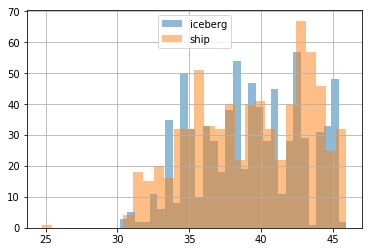

In [3]:
train[train.is_iceberg>0].inc_angle.hist(bins=30,alpha = 0.5, label='iceberg')
train[train.is_iceberg==0].inc_angle.hist(bins=30,alpha = 0.5, label='ship') #.apply(lambda x:np.log1p(x))


plt.legend(loc='upper center')
plt.show()


In [4]:
train.is_iceberg.value_counts()

0    851
1    753
Name: is_iceberg, dtype: int64

In [25]:
851/753.

1.1301460823373175

# Global Image Stats

Now, I will look at some global properties of the images. These are things like the minimum and maximum values, the means, medians, and the 50% mid range of the signal values. There are two different bands used in the file, so I'll do this separately for each band.

In [5]:
def get_stats(train,label=1):
    train['max'+str(label)] = [np.max(np.array(x)) for x in train['band_'+str(label)] ]
    train['maxpos'+str(label)] = [np.argmax(np.array(x)) for x in train['band_'+str(label)] ]
    train['min'+str(label)] = [np.min(np.array(x)) for x in train['band_'+str(label)] ]
    train['minpos'+str(label)] = [np.argmin(np.array(x)) for x in train['band_'+str(label)] ]
    train['med'+str(label)] = [np.median(np.array(x)) for x in train['band_'+str(label)] ]
    train['std'+str(label)] = [np.std(np.array(x)) for x in train['band_'+str(label)] ]
    train['mean'+str(label)] = [np.mean(np.array(x)) for x in train['band_'+str(label)] ]
    train['p25_'+str(label)] = [np.sort(np.array(x))[int(0.25*75*75)] for x in train['band_'+str(label)] ]
    train['p75_'+str(label)] = [np.sort(np.array(x))[int(0.75*75*75)] for x in train['band_'+str(label)] ]
    train['mid50_'+str(label)] = train['p75_'+str(label)]-train['p25_'+str(label)]

    return train
train = get_stats(train,1)
train = get_stats(train,2)

In [6]:
train.shape

(1604, 25)

## Plotting the Statistics

Now, we can make some histograms of these variables. I'll make histograms of both classes to see if there are any differences.

In [27]:
def plot_var(name,nbins=50):
    minval = train[name].min()
    maxval = train[name].max()
    plt.hist(train.loc[train.is_iceberg==1,name],range=[minval,maxval],
             bins=nbins,color='b',alpha=0.5,label='Boat')
    plt.hist(train.loc[train.is_iceberg==0,name],range=[minval,maxval],
             bins=nbins,color='r',alpha=0.5,label='Iceberg')
    plt.legend()
    plt.xlim([minval,maxval])
    plt.xlabel(name)
    plt.ylabel('Number')
    plt.show()

C:\Users\Armin\Anaconda2\lib\site-packages\numpy\lib\function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\Armin\Anaconda2\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


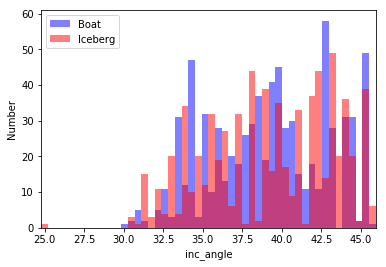

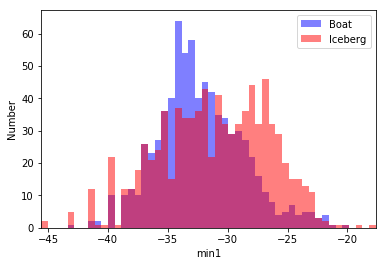

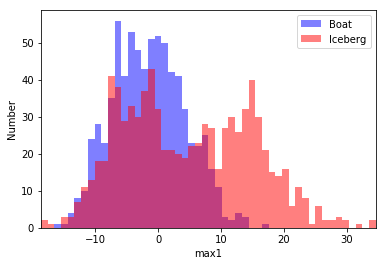

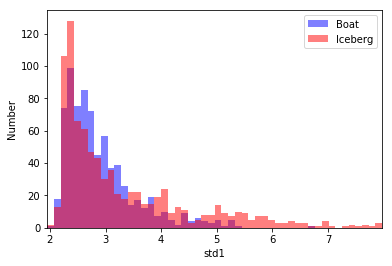

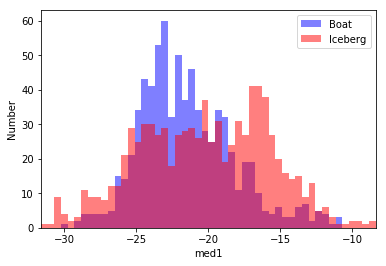

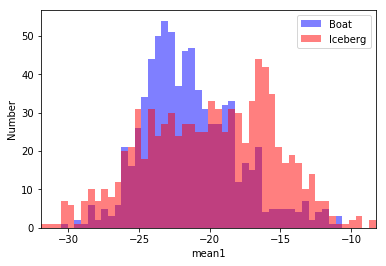

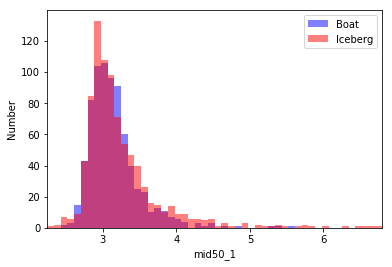

In [29]:
for col in ['inc_angle','min1','max1','std1','med1','mean1','mid50_1']:
    plot_var(col)


For the first band, we see that there are some significant differences. The middle 50% range has around the same size for both, but the minimum, maximum, standard deviation, median, and mean all show noticeable differences in some range of the values. Evidently, these basic variables seem to have some sensitivity to what we are trying to measure. We might expect this if, for example, icebergs are much larger than ships and thus cover more pixels.

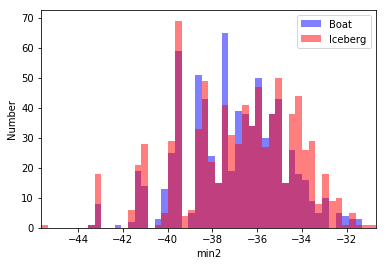

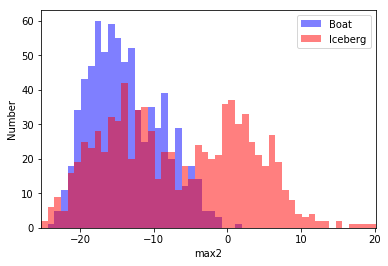

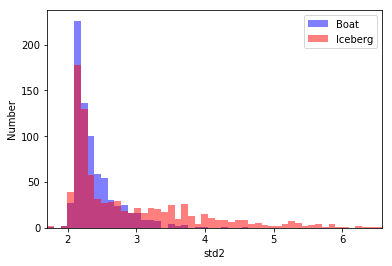

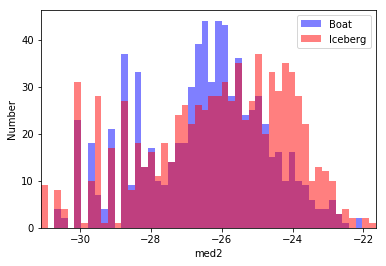

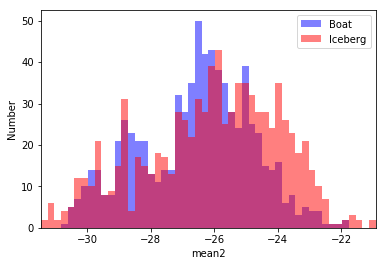

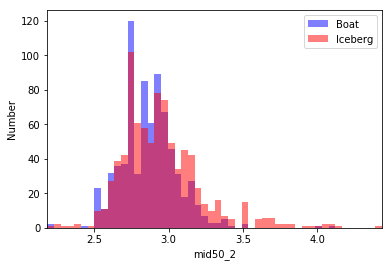

In [6]:
for col in ['min2','max2','std2','med2','mean2','mid50_2']:
    plot_var(col)

We get similar results for the second band.

## Correlations Between Features

Now that we've established that these variables may have some use, we should look at the correlations between them. For this, I'll just plot the correlation matrix. It would also be good to look at scatter plots of each pair of variables (this can be done easily in Seaborn), but i won't do that here.

In [7]:
train_stats = train.drop(['id','is_iceberg','band_1','band_2'],axis=1)

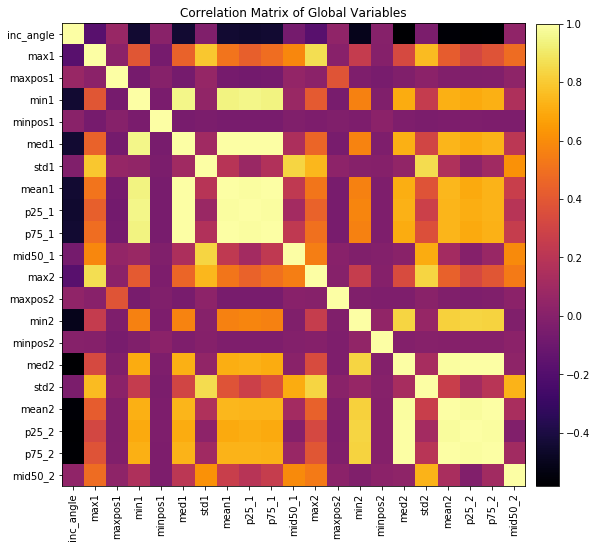

In [8]:
corr = train_stats.corr()
fig = plt.figure(1, figsize=(10,10))
plt.imshow(corr,cmap='inferno')
labels = np.arange(len(train_stats.columns))
plt.xticks(labels,train_stats.columns,rotation=90)
plt.yticks(labels,train_stats.columns)
plt.title('Correlation Matrix of Global Variables')
cbar = plt.colorbar(shrink=0.85,pad=0.02)
plt.show()

We see that there are large correlations between some of the variables. In particular, the mean, median, 25% signal, and 75% signal are all closely related, with nearly 75% correlation. The min and max are also pretty highly correlated for band 1, as are the min and median for both bands, suggesting that the signals have maybe been scaled in some way to force this correlation. There are also some correlations between the two bands. Finally, we see an anticorrelation of around -0.5 between the mean of band 2 and the angle, with a weaker correlation for band 1.

# Plotting Some Images

It's good to plot some images before we do too much analysis. That way, we can get some sense of what we're looking at. The images are 75 x 75 pixels each with two bands.

In [10]:
icebergs = train[train.is_iceberg==1].sample(n=9,random_state=123)
ships = train[train.is_iceberg==0].sample(n=9,random_state=456)

## Raw Images

The first set show 9 random icebergs using band 1.

In [35]:
len(icebergs.iloc[i,0])/75

75

In [7]:
def stretch_8bit(bands, lower_percent=0, higher_percent=100):
    out = np.zeros_like(bands)
    a = 0 
    b = 255 
    c = np.percentile(bands[:,:], lower_percent)
    d = np.percentile(bands[:,:], higher_percent)        
    t = a + (bands[:,:] - c) * (b - a) / (d - c)    
    t[t<a] = a
    t[t>b] = b
    out[:,:] =t
    return out.astype(np.uint8)    

def normalize_photo(arr):
    
    max_r = max(arr)
    if max_r < 0:
        max_r = -max_r
    
    arr[arr>1] = 1 + np.log(arr[arr>1] )
    arr = arr/max_r
    
    return arr

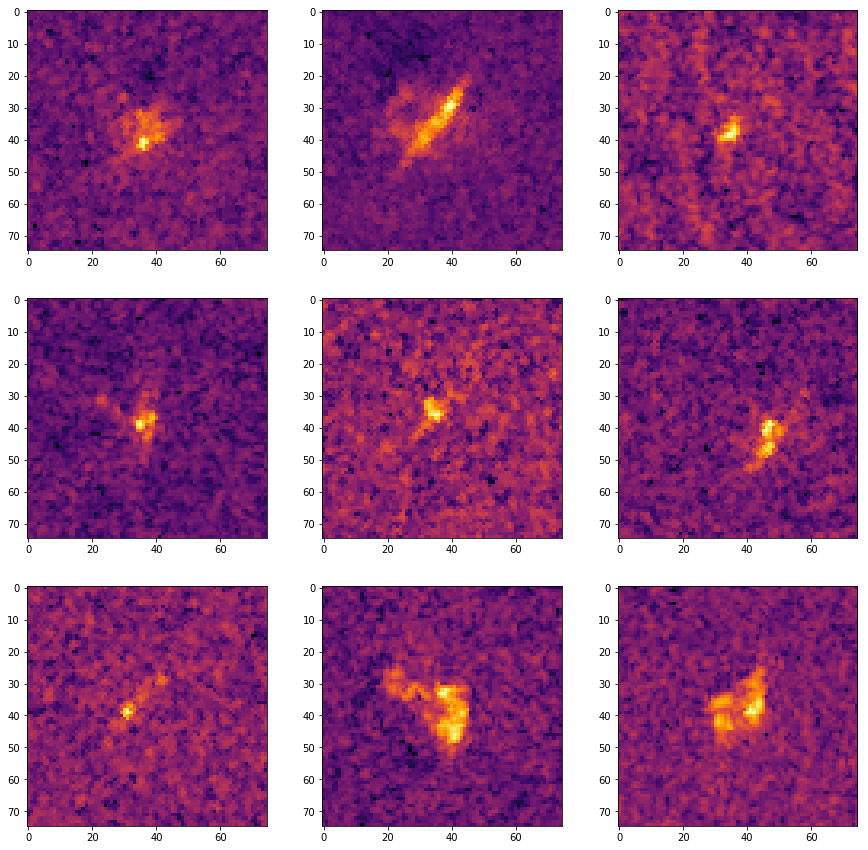

In [14]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(icebergs.iloc[i,0]),(75,75))
    ax.imshow(arr,cmap='inferno')
    
plt.show()

In [15]:
# # Plot band_1
# fig = plt.figure(1,figsize=(15,15))
# for i in range(9):
#     ax = fig.add_subplot(3,3,i+1)
#     arr = np.reshape(normalize_photo(np.array(icebergs.iloc[i,0])),(75,75))
#     ax.imshow(arr,cmap='inferno')
    
# plt.show()

In [16]:
# # Plot band_1
# fig = plt.figure(1,figsize=(15,15))
# for i in range(9):
#     ax = fig.add_subplot(3,3,i+1)
#     arr = stretch_8bit(np.reshape(np.array(icebergs.iloc[i,0]),(75,75)),0.2,99.8)
#     ax.imshow(arr,cmap='inferno')
    
# plt.show()

The second set shows ships in band 1.

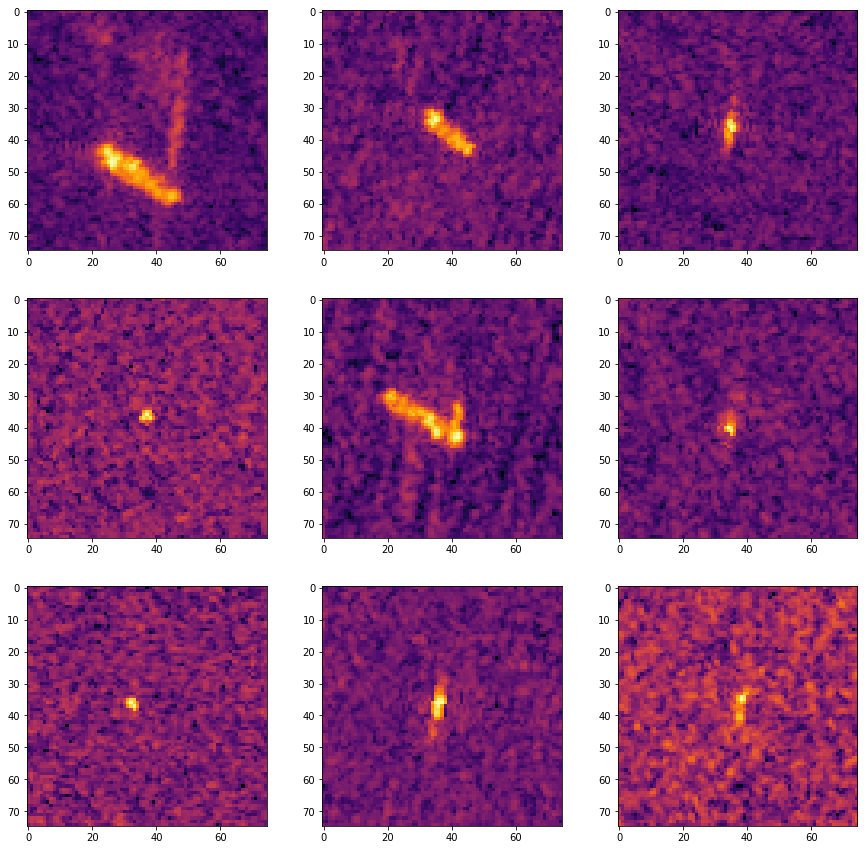

In [17]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(ships.iloc[i,0]),(75,75))
    ax.imshow(arr,cmap='inferno')
    
plt.show()

In [18]:
# # Plot band_1
# fig = plt.figure(1,figsize=(15,15))
# for i in range(9):
#     ax = fig.add_subplot(3,3,i+1)
#     arr = np.reshape(normalize_photo(np.array(ships.iloc[i,0])),(75,75))
#     ax.imshow(arr,cmap='inferno')
    
# plt.show()

In [19]:
# # Plot band_1
# fig = plt.figure(1,figsize=(15,15))
# for i in range(9):
#     ax = fig.add_subplot(3,3,i+1)
#     arr = stretch_8bit(np.reshape(np.array(ships.iloc[i,0]),(75,75)),0.2,99.8)
#     ax.imshow(arr,cmap='inferno')
    
# plt.show()

The next set show the same set of icebergs in band 2.

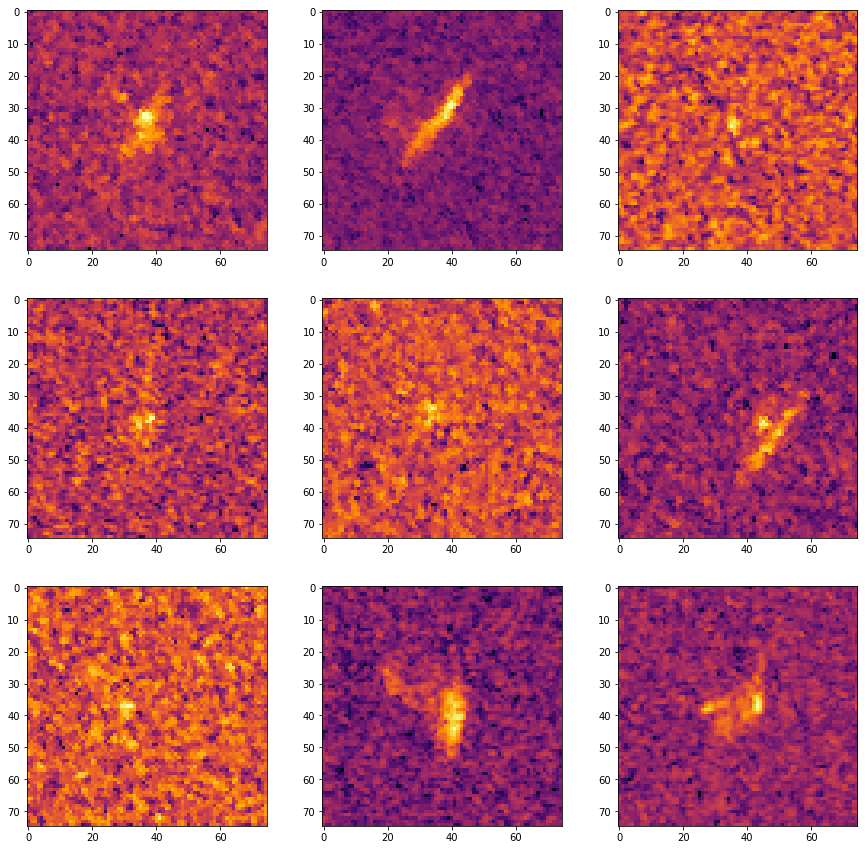

In [20]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(icebergs.iloc[i,1]),(75,75))
    ax.imshow(arr,cmap='inferno')
    
plt.show()

In [21]:
# # Plot band_1
# fig = plt.figure(1,figsize=(15,15))
# for i in range(9):
#     ax = fig.add_subplot(3,3,i+1)
#     arr = np.reshape(normalize_photo(np.array(icebergs.iloc[i,1])),(75,75))
#     ax.imshow(arr,cmap='inferno')
    
# plt.show()

Finally, the last set are the same ship images as before, but for band 2.

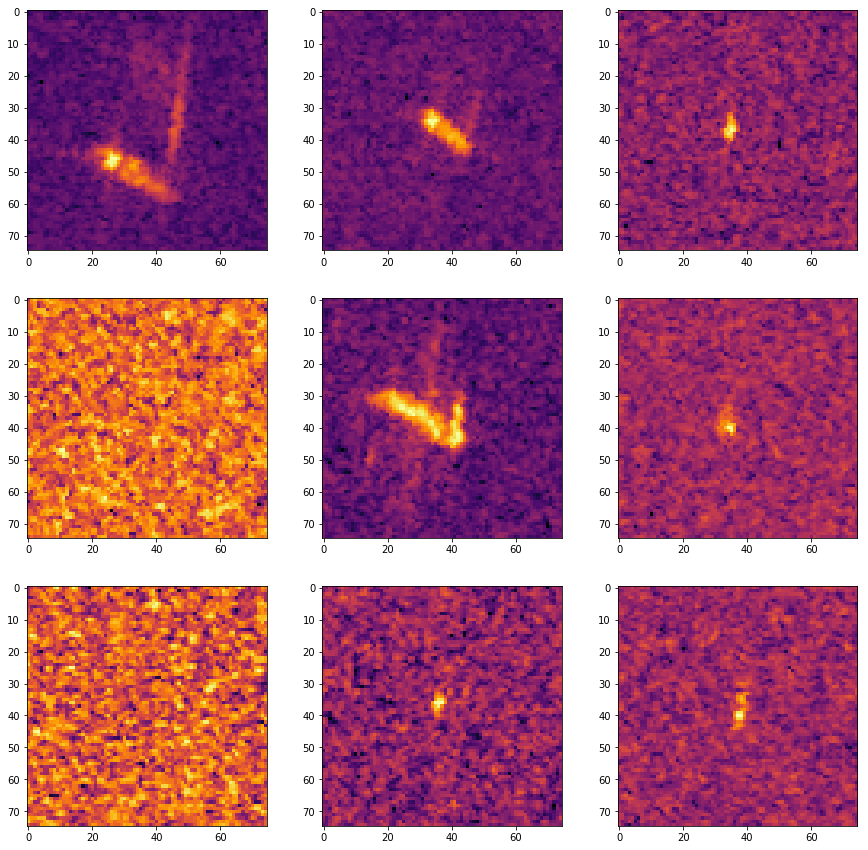

In [23]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(ships.iloc[i,1]),(75,75))
    ax.imshow(arr,cmap='inferno')
    
plt.show()

In [24]:
# # Plot band_1
# fig = plt.figure(1,figsize=(15,15))
# for i in range(9):
#     ax = fig.add_subplot(3,3,i+1)
#     arr = np.reshape(normalize_photo(np.array(ships.iloc[i,1])),(75,75))
#     ax.imshow(arr,cmap='inferno')
    
# plt.show()

So, we see that everything looks pretty blob-like. It also appears that the background is not really random noise but rather has some spatial correlations. If the background is dominated by things like waves rather than noise, then spatial correlations would clearly be expected. The ships seem to have a more regular structure, with a pronounced skewness in the blobs for larger signals.

Some of these blobs are not that high above noise, and in the last set there are even two images where the signal cannot even be seen by eye, so it may be advantageous to first transform the images in some way to enhance the contrast between the signals and the background.

# Transforming the Images

I'll look at a few types of basic transforms that can be easily defined by FIR filters. The scipy convolve2d function will run a convolution of two arrays, so we just need to define the kernels. I have not optimized the kernels here, and there are many other choices of types of kernels, so you should try out different options to see what they do.

In [8]:
from scipy import signal

xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
yder = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
smooth = np.array([[1,1,1],[1,5,1],[1,1,1]])
xder2 = np.array([[-1,2,-1],[-3,6,-3],[-1,2,-1]])
yder2 = np.array([[-1,-3,-1],[2,6,2],[-1,-3,-1]])

### Smoothing

First, let's try smoothing the images. The kernel here just has all positive values and is symmetric in both directions.

I'll first plot the icebergs and then the ships. These are all for Band 1.

In [25]:
# # Plot band_1
# fig = plt.figure(1,figsize=(15,15))
# for i in range(9):
#     ax = fig.add_subplot(3,3,i+1)
#     arr = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,0]),(75,75)),smooth,mode='valid')
#     ax.imshow(arr,cmap='inferno')
#     ax.set_title('Smoothed')
    
# plt.show()

In [26]:
# # Plot band_1
# fig = plt.figure(1,figsize=(15,15))
# for i in range(9):
#     ax = fig.add_subplot(3,3,i+1)
#     arr = signal.convolve2d(np.reshape(np.array(ships.iloc[i,0]),(75,75)),smooth,mode='valid')
#     ax.imshow(arr,cmap='inferno')
#     ax.set_title('Smoothed')
    
# plt.show()

As we might expect, smoothing blurs the features. However, it also enhances the contrast between bright and dark regions, so it may be quite useful if we want to use it to seed some clusters in a cluster/peak finder.

### Derivative with Respect to X

An X-derivative will typically be antisymmetric with respect to reversing the values around the x-axis. This will provide some level of edge detection in the x-direction. I will take the derivatives of the original images.

In [27]:
# # Plot band_1
# fig = plt.figure(1,figsize=(15,15))
# for i in range(9):
#     ax = fig.add_subplot(3,3,i+1)
#     arr = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,0]),(75,75)),xder,mode='valid')
#     ax.imshow(arr,cmap='inferno')
#     ax.set_title('X-derivative')
    
# plt.show()

In [28]:
# # Plot band_1
# fig = plt.figure(1,figsize=(15,15))
# for i in range(9):
#     ax = fig.add_subplot(3,3,i+1)
#     arr = signal.convolve2d(np.reshape(np.array(ships.iloc[i,0]),(75,75)),xder,mode='valid')
#     ax.imshow(arr,cmap='inferno')
#     ax.set_title('X-derivative')
    
# plt.show()

Note that you should see a dark region on the left side of a peak and a bright region on the right. If you look closely enough, you should see that the positions may have changed in all of these transformations. This is because I have chosen not to zero-pad the arrays. The resulting transformed arrays are slightly smaller than the input.

### Gradient Magnitude

It should also be trivial to see how to do a y-derivative. Rather than that, we can look at the magnitude of the gradient. That is, treat the x and y derivatives as a gradient vector at each position and then take the magnitude at each point.

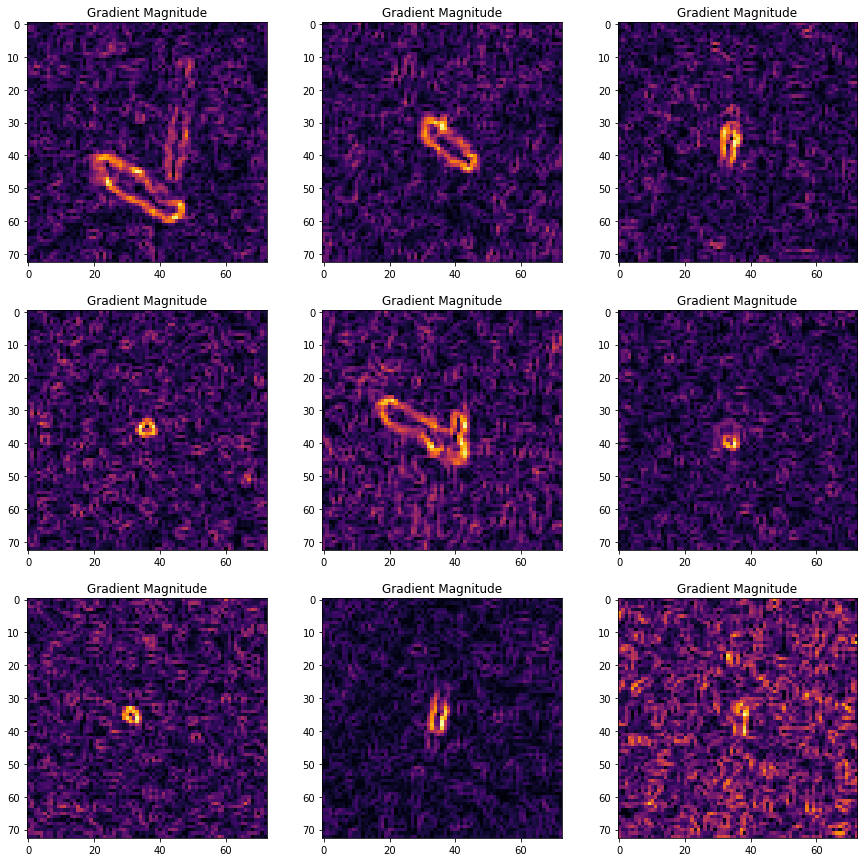

In [31]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(ships.iloc[i,0]),(75,75)),xder,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(ships.iloc[i,0]),(75,75)),yder,mode='valid')
    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    ax.set_title('Gradient Magnitude')
    
plt.show()

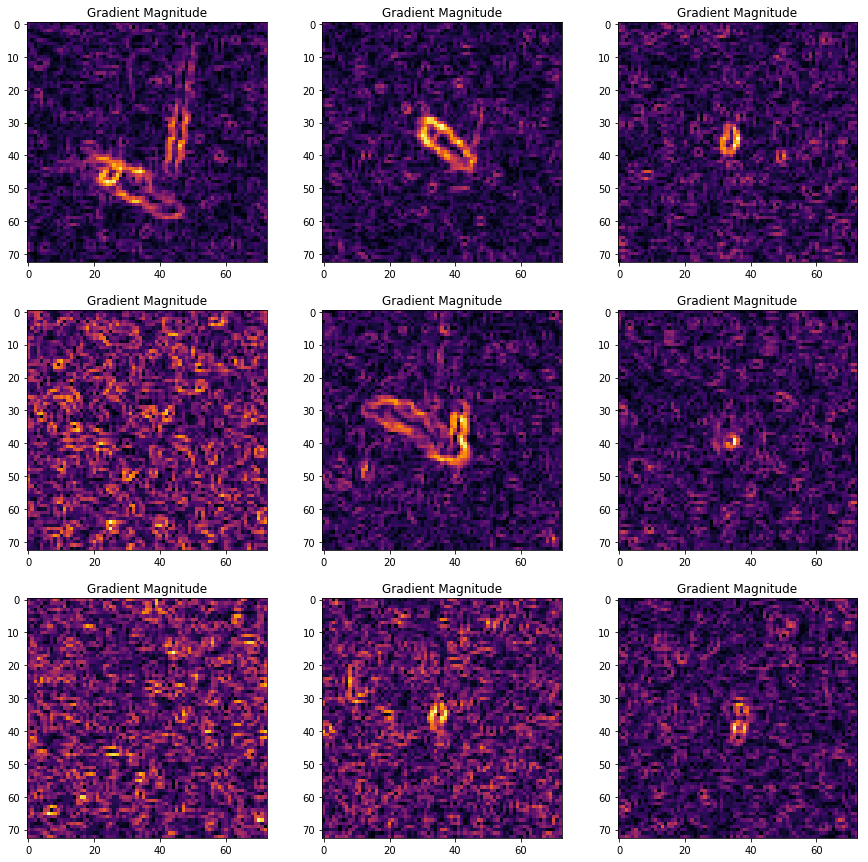

In [32]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(ships.iloc[i,1]),(75,75)),xder,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(ships.iloc[i,1]),(75,75)),yder,mode='valid')
    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    ax.set_title('Gradient Magnitude')
    
plt.show()

####  Ships


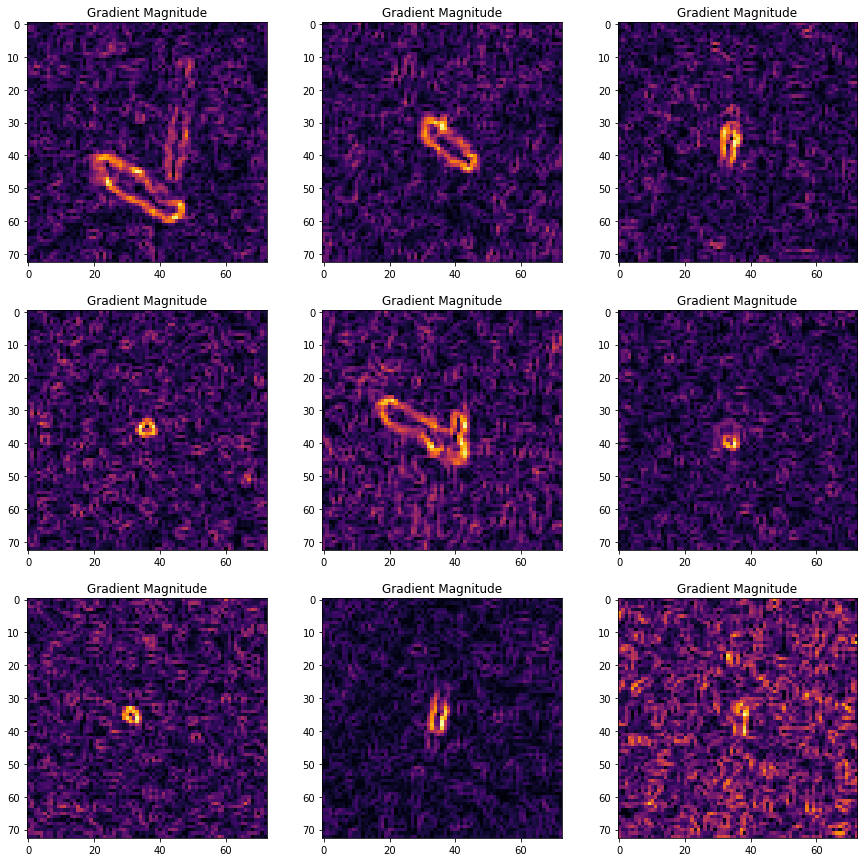

In [12]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(ships.iloc[i,0]),(75,75)),xder,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(ships.iloc[i,0]),(75,75)),yder,mode='valid')
    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    ax.set_title('Gradient Magnitude')
    
plt.show()

We see interesting circular shapes everywhere in these images. But, the signals look fairly strong. The ships, in particular, show fairly bright edges and most create nice loops. This sort of operator might be useful to put into a more advanced model like a neural net. At the very least, it would be good to compare the results using this against things like the raw and smoothed data. 

### Second Derivatives

We can also define a simple second-derivative operator. A 3x3 second derivative should do less smoothing than a 3x3 first derivative, so we might see less contrast between the signal and the background.

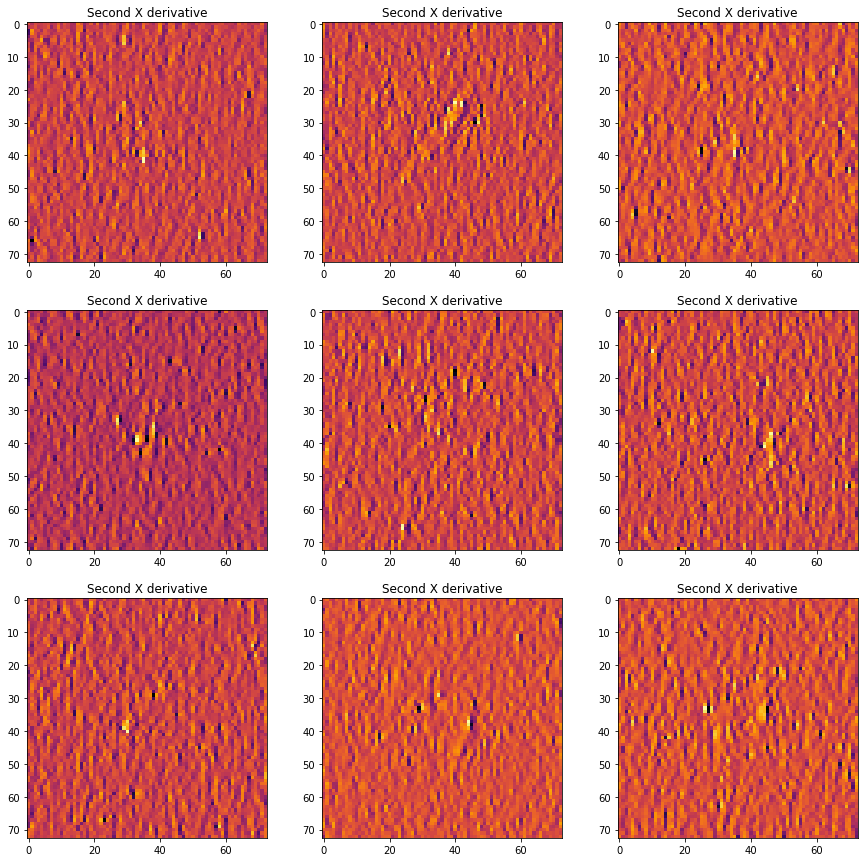

In [21]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,0]),(75,75)),xder2,mode='valid')
    ax.imshow(arr,cmap='inferno')
    ax.set_title(r'Second X derivative')
    
plt.show()

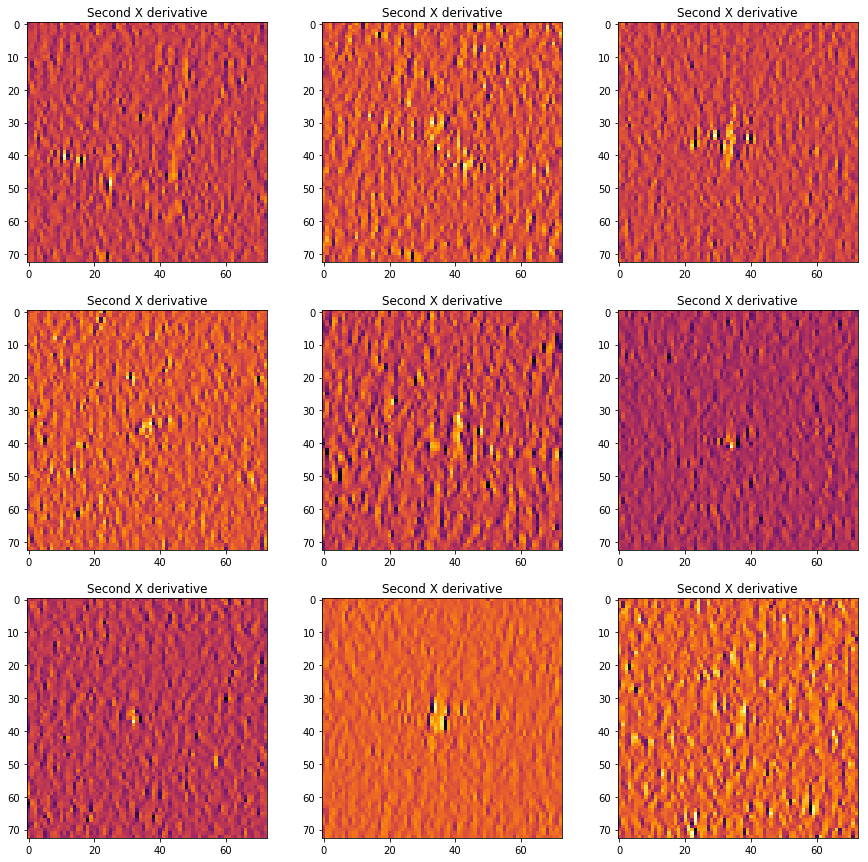

In [22]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = signal.convolve2d(np.reshape(np.array(ships.iloc[i,0]),(75,75)),xder2,mode='valid')
    ax.imshow(arr,cmap='inferno')
    ax.set_title(r'Second X derivative')
    
plt.show()

Here, we do see that the signals are not particularly obvious. The ships are a bit more visible, but the noise looks like it may be quite problematic here unless we do more smoothing.

### Laplacian

The Laplacian operator is just the sum of second derivatives, or the divergence of the gradient.

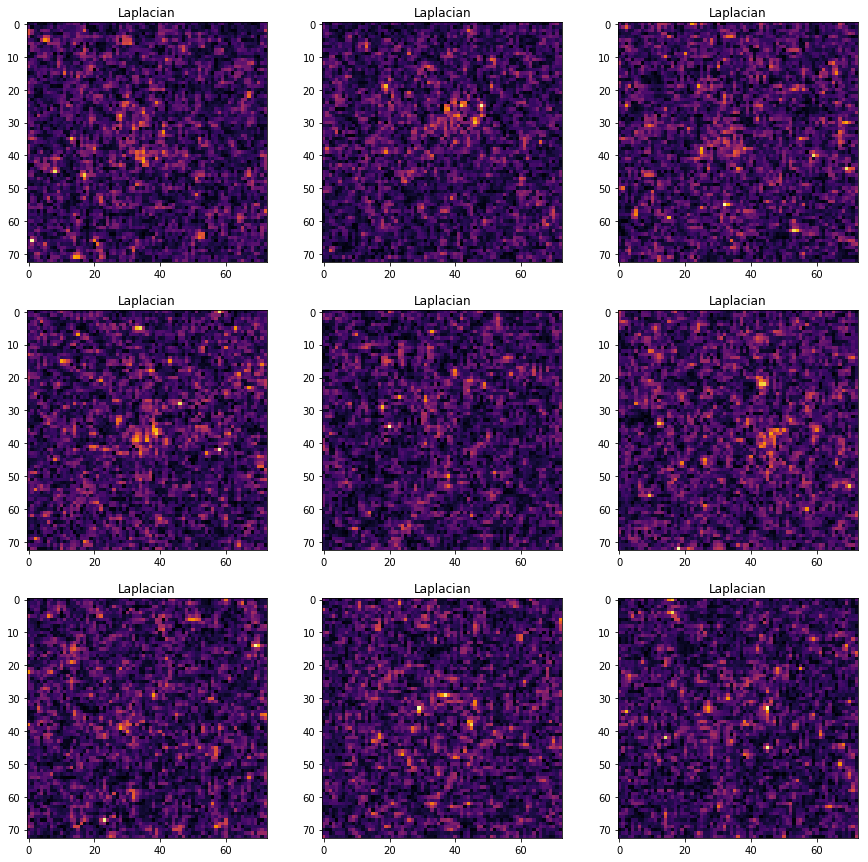

In [23]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,0]),(75,75)),xder2,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,0]),(75,75)),yder2,mode='valid')

    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    ax.set_title('Laplacian')
    
plt.show()

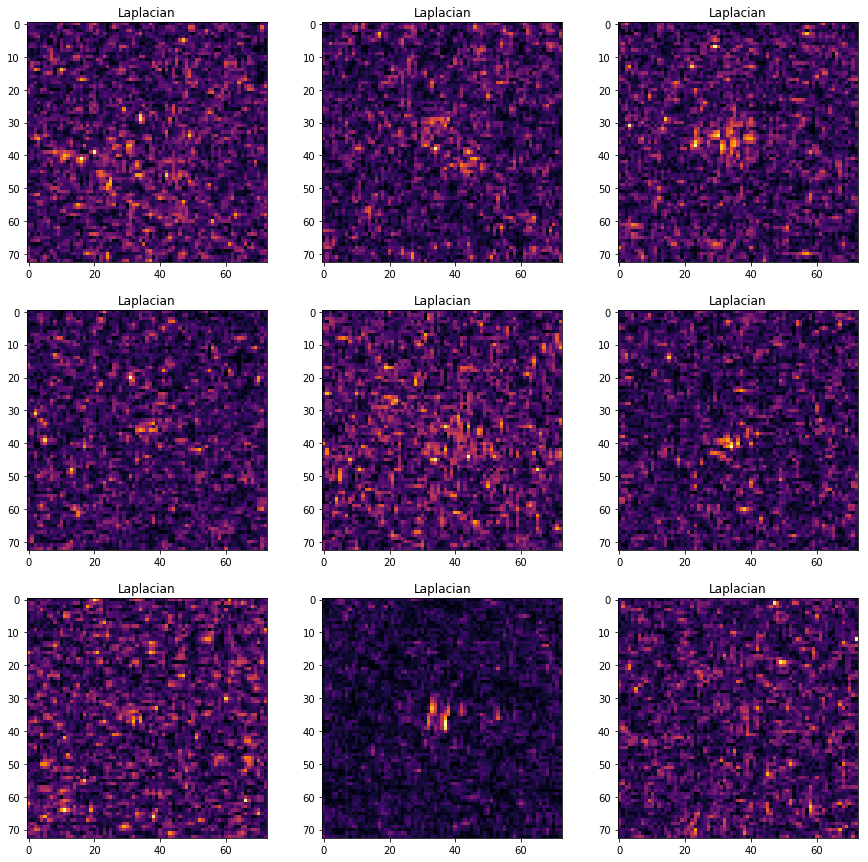

In [24]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(ships.iloc[i,0]),(75,75)),xder2,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(ships.iloc[i,0]),(75,75)),yder2,mode='valid')

    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    ax.set_title('Laplacian')
    
plt.show()

We see interesting vertical and horizontal line features in the Laplacian images, but the signals are mostly difficult to see and split into many small clusters. Again, second derivatives probably require more smoothing to be useful.

### Magnitude of the Curl of Gradient

There are many other things that we can look at. The last one I'll do is the magnitude of the curl of the gradient. For a differentiable function, this actually is supposed to be exactly 0, but for our discrete images, this likely isn't the case. I wouldn't expect this to be useful though.

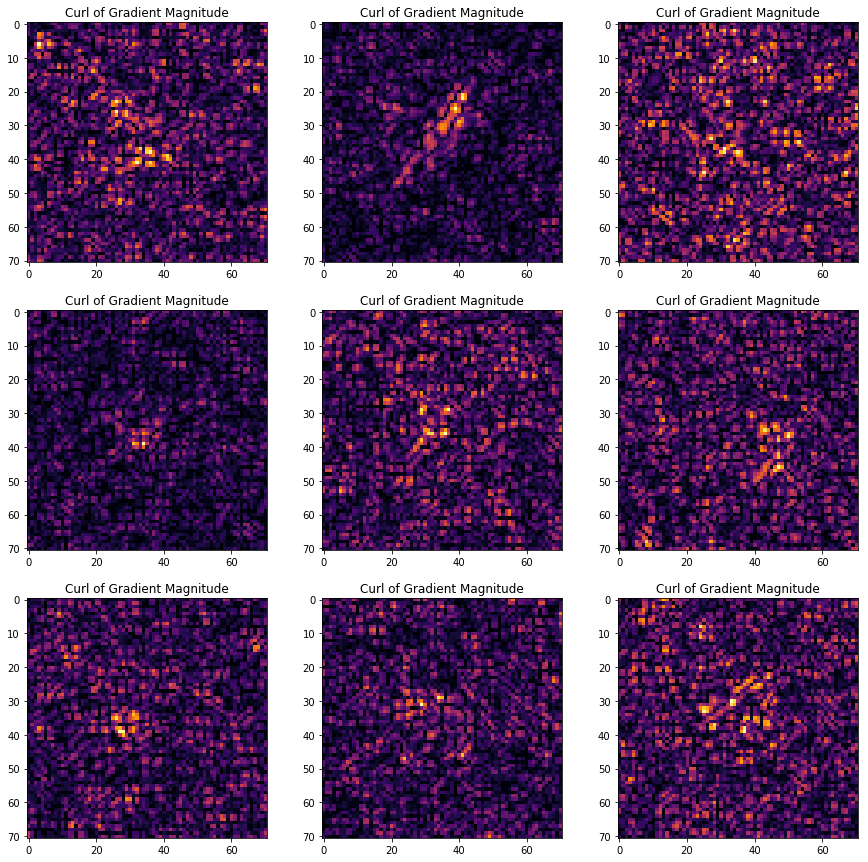

In [25]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,0]),(75,75)),xder,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,0]),(75,75)),yder,mode='valid')
    arrx = signal.convolve2d(arrx,yder,mode='valid')
    arry = signal.convolve2d(arry,xder,mode='valid')
    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    ax.set_title('Curl of Gradient Magnitude')
    
plt.show()

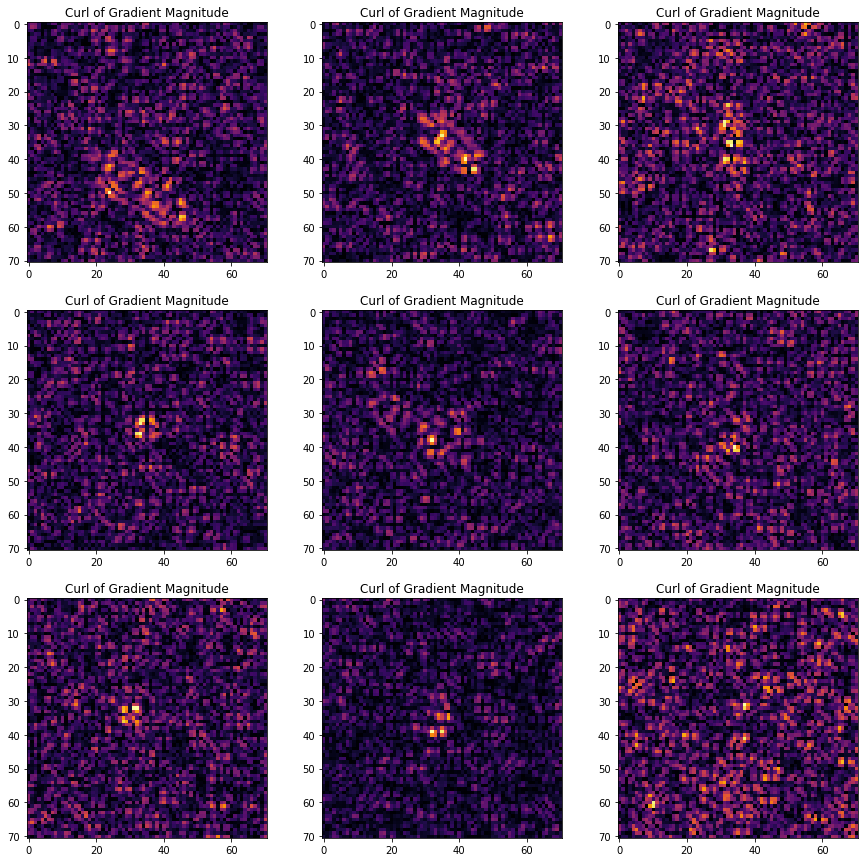

In [26]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(ships.iloc[i,0]),(75,75)),xder,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(ships.iloc[i,0]),(75,75)),yder,mode='valid')
    arrx = signal.convolve2d(arrx,yder,mode='valid')
    arry = signal.convolve2d(arry,xder,mode='valid')
    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    ax.set_title('Curl of Gradient Magnitude')
    
plt.show()

We can see that as expected, it will at best be of limited usefulness. However, we do get some nice looking images. we see a number of small, separated tiles. Even if it's not useful for analysis, we get some nice textures by transforming the images with this particular transformation.

# Conclusions

We've constructed some global features from the images and found that there are some noticeable differences between icebergs and ships even just from those. However, I would expect that a classifier based only on global statistics will not be very effective.

We've also looked at a number of transformations of the images. Edge detection (gradient)-based methods seem to get some nice features, and smoothing may help out with images with small signal size.